In [2]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import gurobipy as gp
from gurobipy import GRB
import cvxpy as cp

import random
from itertools import chain, combinations, tee
import time


# Load Input Data:

In [3]:
vot_pdf = np.genfromtxt('../original_code/VOT_distr.csv', delimiter=',')[1:]
vots = []
vot_p_orig = []
for row in vot_pdf:
    vots.append(row[0])
    vot_p_orig.append(row[1])
print("vot_p_orig:", vot_p_orig)
print()
vot_p = vot_p_orig/np.sum(vot_p_orig)
print("vot_p:\n", vot_p)

vot_p_orig: [0.01, 0.02, 0.01, 0.02, 0.02, 0.02, 0.02, 0.04, 0.02, 0.07, 0.02, 0.07, 0.16, 0.13, 0.05, 0.25, 0.03, 0.05]

vot_p:
 [0.00990099 0.01980198 0.00990099 0.01980198 0.01980198 0.01980198
 0.01980198 0.03960396 0.01980198 0.06930693 0.01980198 0.06930693
 0.15841584 0.12871287 0.04950495 0.24752475 0.02970297 0.04950495]


# Travel time functions:

In [4]:
###### BPR Parameters ###### 
bpr_true_capacity = 66
bpr_true_fftt = 60*22/67
bpr_true_alpha = 0.2

def true_bpr_cost(flow_val, fftt = bpr_true_fftt, capacity = bpr_true_capacity, alpha = bpr_true_alpha):
    """
    Find the (exact) travel time on an edge given an edge flow
    """

    return fftt * (1+alpha*(flow_val/capacity)**6)

###### Approximation Parameters ###### 
const_multiplier = 1
cap_thresh_multiplier = 0.7835
apx_slope = 0.314

def apx_bpr_cost(flow_val, fftt = bpr_true_fftt, capacity = bpr_true_capacity, 
                a = const_multiplier, cap_thresh = cap_thresh_multiplier, b = apx_slope):
    """
    Find the (approximate) travel time on an edge given an edge flow
    """
    
    if flow_val <= cap_thresh*capacity:
        return a*fftt
    else:
        return a*fftt + b*(flow_val - cap_thresh*capacity)

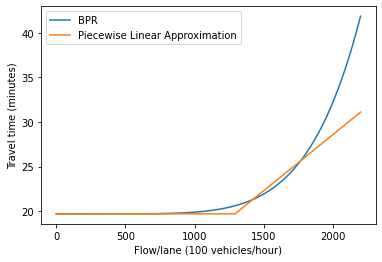

In [5]:
###### Check plots of BPR and approximation ###### 
multiplier = 100/4 # converts from 100 vehicles/hour --> vehicle/hour per lane

x =  np.linspace(0,int(np.round(88*multiplier,0)),int(np.round(89*2*multiplier,0)))
y = [true_bpr_cost(i, capacity = bpr_true_capacity*multiplier) for i in x]

plt.plot(x, y,label='BPR')

y_apx = [apx_bpr_cost(i,capacity = bpr_true_capacity*multiplier, b = apx_slope/multiplier) for i in x]

plt.plot(x, y_apx,label='Piecewise Linear Approximation')
plt.xlabel("Flow/lane (100 vehicles/hour)")
plt.ylabel("Travel time (minutes)")
plt.legend(loc='upper left')

# Generate Demand Profile:

In [29]:
num_eligible_factor = 10.0

###### Specify parameters for problem ###### 
T = 5 # Time Horizon
tau_arr = 20*np.linspace(0, 1, 21)[0:] # Toll discretization
print('Tau:\n {}'.format(tau_arr))
print()

B_arr = np.linspace(tau_arr[0], tau_arr[-3]*T,19) # Budget discretization 
print('B:\n {}'.format(B_arr))
print()

num_total = 8000 # number of users
num_eligible =int( num_total*.17) # number of eligible users
num_ineligible = num_total-num_eligible # number of ineligible users

###### VoT information ###### 
vot_all = np.sort(np.round(np.random.choice(vots, size = num_total, p=vot_p),2)/60) # generate baseline VoT for all users
vot_all_days = np.empty(shape=(num_total,T)) 
count=0
for v in vot_all:
    if count < num_eligible:
        vot_all_days[count,:]=[v*num_eligible_factor
                               for t in range(T)] # VoT of eligible users does not vary over time periods
    else:
        vot_all_days[count,:]=list((1+0.25*(np.random.random_sample(size=T)-0.5))*v) # VoT of ineligible users varies over time periods
    count+=1
    
vot_eligible = vot_all_days[:num_eligible,:]
vot_ineligible= vot_all_days[num_eligible:,:]

print('Eligible vot range:\n {} ({} $/hr), {} ({} $/hr)'.format(np.min(vot_eligible),60*np.min(np.round(vot_eligible,2)),np.max(np.round(vot_eligible,2)),60*np.max(np.round(vot_eligible,2))))
print()
print('Ineligible vot range:\n {}({} $/hr), {} ({} $/hr)'.format(np.min(np.round(vot_ineligible,2)),60*np.min(np.round(vot_ineligible,2)),np.max(np.round(vot_ineligible,2)),60*np.max(np.round(vot_ineligible,2))))
print()
print('Mean vot:\n {} $/hr; median: {} $/hr'.format(60*np.round(np.mean(vot_all_days),2),60*np.round(np.median(vot_all_days),2)))

Tau:
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]

B:
 [ 0.  5. 10. 15. 20. 25. 30. 35. 40. 45. 50. 55. 60. 65. 70. 75. 80. 85.
 90.]

Eligible vot range:
 0.2 (12.0 $/hr), 2.4 (144.0 $/hr)

Ineligible vot range:
 0.21(12.6 $/hr), 2.7 (162.0 $/hr)

Mean vot:
 55.800000000000004 $/hr; median: 48.0 $/hr


In [30]:
print("vot_all:", vot_all)
print("num_eligible_factor:", num_eligible_factor)

vot_all: [0.02       0.02       0.02       ... 2.40383333 2.40383333 2.40383333]
num_eligible_factor: 10.0


Text(0, 0.5, '% of population')

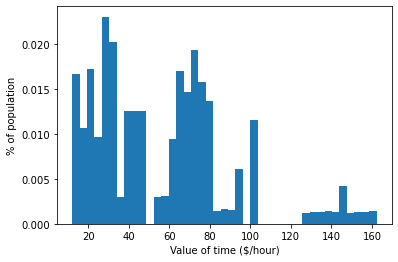

In [31]:
###### Check VoT distribution ###### 
plt.hist(vot_all_days.flatten()*60,bins=41,density=True)
plt.xlabel("Value of time ($/hour)")
plt.ylabel("% of population")

In [32]:
print("len(vots):", len(vots))
print()
print("len(vot_p):", len(vot_p))

print()

print("vots:", vots)
print()
print("vot_p:", vot_p)

len(vots): 18

len(vot_p): 18

vots: [1.2, 2.4, 3.0, 4.81, 6.01, 7.21, 9.62, 10.22, 14.42, 15.02, 20.43, 21.03, 30.05, 42.07, 60.1, 72.12, 84.13, 144.23]

vot_p: [0.00990099 0.01980198 0.00990099 0.01980198 0.01980198 0.01980198
 0.01980198 0.03960396 0.01980198 0.06930693 0.01980198 0.06930693
 0.15841584 0.12871287 0.04950495 0.24752475 0.02970297 0.04950495]


# Define Social Objectives of Interest:

In [33]:
###### Estimate VoT percentiles for ineligible group ###### 
percentiles = {}
thresh = 10
for p in range(11):
    print(np.round(np.percentile(vot_ineligible,p*10)*60,2))
    percentiles[p*10]=np.percentile(vot_ineligible,p*10)

12.62
18.93
26.49
30.58
37.94
44.54
64.13
69.21
74.94
80.31
162.26


# Solver 2, Discount:

In [34]:
# Solver 2, Discount:

def OptPL_discount(toll, discount_ratio, T = T, num_eligible = num_eligible, num_ineligible = num_ineligible, 
            vot_ineligible = vot_ineligible, alpha = bpr_true_alpha, fftt_1 = bpr_true_fftt, 
              fftt_2 = bpr_true_fftt, c_1 = bpr_true_capacity, c_2 = bpr_true_capacity, 
             a = const_multiplier, cap_thresh = cap_thresh_multiplier, b_1 = apx_slope, b_2 = apx_slope):
    """
    Function to solve convex optimization problem given a particular toll and budget value
    """
    
    # Initialize model
    m1 = gp.Model()
    # Add variables to model
#     users_in = m1.addVars(num_ineligible, 3, T, name = 'ineligible_val', lb = 0.0, ub = 2.0)
#     edge_flows = m1.addVars(2, T, name = 'edge_flows', lb = 0.0, ub = num_ineligible * 2.0)
#     users_el = m1.addVars(3, T, name = 'eligible_allocation', lb = 0.0, ub = 2.0)
    # Add variables for piecewise affine approximation
#     eps_flows = m1.addVars(2, T, name = 'eps_flows', lb = 0.0, ub = num_ineligible * 2.0)
    
#     # Add variables for piecewise affine approximation
#     eps_flows = m1.addVars(2, T, name = 'eps_flows', lb = 0.0, ub = num_ineligible * 2.0)
    users_in = m1.addVars(num_ineligible, 2, T, name = 'ineligible_val', lb = -10000.0, ub = 10000.0)
    edge_flows = m1.addVars(2, T, name = 'edge_flows', lb = -10000.0, ub = 10000.0)
    users_el = m1.addVars(2, T, name = 'eligible_allocation', lb = -10000.0, ub = 10000.0)
    eps_flows = m1.addVars(2, T, name = 'eps_flows', lb = -10000.0, ub = 10000.0)   

    ## Add constraints to Model 
    
    # Total edge flow, express and general purpose lanes:
    m1.addConstrs((edge_flows[j, t] == sum(users_in[i, j, t] for i in range(num_ineligible)) + \
                  users_el[j, t] for j in range(2) for t in range(T)))
    
    # Non-negativity of flows, and zero flow for "eligible users in ineligible groups":
    m1.addConstrs((users_in[i, j, t]>=0 for i in range(num_ineligible) for j in range(2) for t in range(T)))
    m1.addConstrs((users_el[j, t]>=0 for j in range(2) for t in range(T)))
    
    # Every eligible and ineligible user is assigned to one of two options: \
    # (express paying, non-express)
    m1.addConstrs((sum(users_in[i, j, t] for j in range(2)) == 1 for i in range(num_ineligible) for t in range(T)))
    m1.addConstrs((sum(users_el[j, t] for j in range(2)) == num_eligible for t in range(T)))
        
    # Piecewise affine approximation:
    m1.addConstrs((eps_flows[j, t] >= 0 for j in range(2) for t in range(T))) # Must be at least 0
    m1.addConstrs((eps_flows[0, t] >= edge_flows[0, t] - cap_thresh*c_1 for t in range(T))) # Must be at least flow - capacity
    m1.addConstrs((eps_flows[1, t] >= edge_flows[1, t] - cap_thresh*c_2 for t in range(T))) # Must be at least flow - capacity
    
    # Set Objective
    m1.setObjective(sum( a*fftt_1*(edge_flows[0, t]) + b_1*(eps_flows[0, t]**2)/2  
                        + a*fftt_2*(edge_flows[1, t]) + b_2*(eps_flows[1, t]**2)/2 
                        + sum( toll*users_in[i,0,t]/vot_ineligible[i,t] for i in range(num_ineligible))
                        + sum( (1 - discount_ratio)*toll*users_el[0,t]/vot_eligible[i,t] for i in range(num_eligible))
        for t in range(T)), GRB.MINIMIZE)
    
    m1.update()
    
    return m1

In [35]:
print("vot_ineligible:", vot_ineligible)
print("\n")
print("vot_eligible:", vot_eligible)

vot_ineligible: [[0.24563261 0.25434256 0.22457122 0.22896814 0.22699928]
 [0.27019876 0.21385871 0.22968334 0.25445985 0.2611332 ]
 [0.2418303  0.26697897 0.24509647 0.26854301 0.26455167]
 ...
 [2.18095421 2.32895463 2.30869782 2.38997065 2.5649683 ]
 [2.61186904 2.62162994 2.28064306 2.66615755 2.10615656]
 [2.3439519  2.35073144 2.25442214 2.38531639 2.36492149]]


vot_eligible: [[0.2        0.2        0.2        0.2        0.2       ]
 [0.2        0.2        0.2        0.2        0.2       ]
 [0.2        0.2        0.2        0.2        0.2       ]
 ...
 [2.40333333 2.40333333 2.40333333 2.40333333 2.40333333]
 [2.40333333 2.40333333 2.40333333 2.40333333 2.40333333]
 [2.40333333 2.40333333 2.40333333 2.40333333 2.40333333]]


In [36]:
def _extract_solution_discount(m, num_ineligible = num_ineligible):
    """
    Get solution from optimization model
    """
    users_in = [v.x for v in m.getVars() if v.VarName.find("ineligible_val") != -1]
    users_el = [v.x for v in m.getVars() if v.VarName.find("eligible_allocation") != -1]
    edge_flows = [v.x for v in m.getVars() if v.VarName.find("edge_flows") != -1]
    eps_flows = [v.x for v in m.getVars() if v.VarName.find("eps_flows") != -1]
    
    users_in = np.reshape(users_in, (num_ineligible, 2, T))
    users_el = np.reshape(users_el, (2, T))
    edge_flows = np.reshape(edge_flows, (2, T))
    eps_flows = np.reshape(eps_flows, (2, T))

    solution = {
        "users_in": users_in,
        "users_el": users_el,
        "edge_flows": edge_flows,
        "eps_flows": eps_flows
    }
    return solution

In [37]:
def to_str(num):
    num = int(num)
    
    # For any number < 100:
    if num < 10:
        return str(0) + str(num)
    else:
        return str(num)

# Solve Optimization Problem for Discretized Grid:

## Case 2 - Discount:

In [38]:
# tau_arr = 20 * np.linspace(0, 1, 21)[0:] # Toll discretization
# B_arr = np.linspace(tau_arr[0], tau_arr[-3]*T,19) # Budget discretization 
# print(tau_arr)
# print()
# print(B_arr)
# print()

In [41]:
t_1 = time.time()

demand_multiplier = [25,75]

# For saving data:

num_eligible_factor_as_str = str(int(num_eligible_factor))

if num_eligible_factor == 0.0:
    path_directory = "/Users/chih-yuanchiu/Desktop/Code/CBCP_Credit_Discount/data/data_discount/"
else:
    path_directory = "/Users/chih-yuanchiu/Desktop/Code/CBCP_Credit_Discount/data/data_discount_" + num_eligible_factor_as_str + "x/"

row_names = ["Edge flows", "Eps flows", "Eligible User Flows"]
row_names += ["Ineligible User Flow, " + str(k) for k in list(range(num_ineligible + 1))[1:]]

column_names = []
workday_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
lane_names = ["Express", "General Purpose"]
for workday_index, workday in enumerate(workday_names):
    for lane_index, lane in enumerate(lane_names):
        column_names.append(workday + ", " + lane)

## Toll and budget lists:
tau_arr = 20 * np.linspace(0, 1, 21)[0:] # Toll discretization
B_arr = np.linspace(tau_arr[0], tau_arr[-3]*T,19) # Budget discretization 

## For debugging purposes, truncate tau_arr and B_arr:
# tau_arr = [0.0, 5.0, 10.0, 15.0, 20.0]
# B_arr = [0.0, 5.0, 10.0, 15.0, 20.0]
# tau_arr = [20]
# tau_arr = 20 * np.linspace(0, 1, 11)[0:] 
# B_arr = np.linspace(0, tau_arr[-1]*4, 9)
# tau_arr = [2.0]
# B_arr = [0.0]


total_count = len(tau_arr) * len(B_arr)

for toll_idx, toll in enumerate(tau_arr):
    for budget_idx, budget in enumerate(B_arr):
        
        if budget >= toll * T or budget == 0 or toll == 0:
            continue
        
        discount_ratio = budget/(toll*T) if (toll != 0 and budget < toll*T) else 1
        print()
        print("Toll:", toll)
        print("Budget:", budget)
        print("Discount Ratio:", discount_ratio)
        print()
        
        m_discount = OptPL_discount(toll, discount_ratio, T = T, num_eligible = num_eligible, num_ineligible = num_ineligible, 
                    vot_ineligible = vot_ineligible, alpha = bpr_true_alpha, fftt_1 = bpr_true_fftt, 
                      fftt_2 = bpr_true_fftt, c_1 = bpr_true_capacity*demand_multiplier[0], c_2 = bpr_true_capacity*demand_multiplier[1], 
                     a = const_multiplier, cap_thresh = cap_thresh_multiplier, b_1 = apx_slope/demand_multiplier[0], b_2 = apx_slope/(demand_multiplier[1]))

        m_discount.optimize()
        
        # Extract Solution:
        solution_set = _extract_solution_discount(m_discount)
        
        if toll == tau_arr[0]:
            print()
            print("Edge flows:", solution_set["edge_flows"])
            print()
            
        ### Frank - To modify below:
        # Storing data:
        data_edge_flows = solution_set["edge_flows"].T.reshape(10)
        data_eps_flow = solution_set["eps_flows"].T.reshape(10)
        data_users_el = solution_set["users_el"].T.reshape(10)
        data_users_in = solution_set["users_in"].transpose(0, 2, 1).reshape((num_ineligible, 5*2))
        data = np.vstack((data_edge_flows, data_eps_flow, data_users_el, data_users_in))
        
        file_name = path_directory + "toll_" + to_str(toll) + "_discount_" + to_str(budget) + ".csv"
        df = pd.DataFrame(data, columns = column_names, index = row_names)        
        df.to_csv(file_name)
        
                

t_2 = time.time()
print("Run time:", t_2 - t_1)


Toll: 2.0
Budget: 5.0
Discount Ratio: 0.5

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x7a849cf4
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e-01, 2e+03]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.15s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual

  16   8.71365503e+05  8.71360110e+05  3.75e-09 5.68e-14  2.54e-06     0s
  17   8.71362980e+05  8.71361824e+05  2.32e-09 1.14e-13  5.44e-07     0s
  18   8.71362473e+05  8.71362272e+05  4.40e-10 3.55e-15  9.44e-08     0s
  19   8.71362386e+05  8.71362349e+05  3.83e-10 5.68e-14  1.74e-08     0s
  20   8.71362369e+05  8.71362365e+05  4.66e-11 5.68e-14  2.11e-09     0s

Barrier solved model in 20 iterations and 0.32 seconds (0.21 work units)
Optimal objective 8.71362369e+05


Toll: 3.0000000000000004
Budget: 15.0
Discount Ratio: 0.9999999999999999

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0xbb6200f1
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e-13, 2e+01]
  

  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.12s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -6.88564555e+09 -6.05958136e+08  6.64e+06 8.04e+02  1.00e+06     0s
   1  -2.34654546e+08 -3.96733697e+08  2.36e+05 2.86e+01  3.59e+04     0s
   2   6.50075031e+06 -2.81966847e+08  3.98e+03 4.82e-01  6.75e+02     0s
   3   5.40003987e+06 -2.99474569e+08  2.28e+03 2.77e-01  4.51e+02     0s
   4   1.68121004e+06 -4.14425885e+08  1.89e+02 2.29e-02  1.42e+02     0s
   5   1.13867681e+06 -1.30941902e+08  1.60e+00 1.93e-04  3.12e+01     0s
   6

  22   8.83972422e+05  8.83941806e+05  2.18e-08 1.34e-12  3.60e-06     0s
  23   8.83967362e+05  8.83942428e+05  1.92e-08 9.88e-13  2.93e-06     0s
  24   8.83961717e+05  8.83944229e+05  1.50e-08 6.87e-13  2.06e-06     0s
  25   8.83959085e+05  8.83944690e+05  1.02e-08 5.17e-13  1.69e-06     0s
  26   8.83956067e+05  8.83945432e+05  8.05e-09 3.39e-13  1.25e-06     0s
  27   8.83953383e+05  8.83946145e+05  4.49e-09 1.87e-13  8.51e-07     0s
  28   8.83950627e+05  8.83947253e+05  1.24e-09 5.68e-14  3.97e-07     0s
  29   8.83949076e+05  8.83948113e+05  8.31e-10 5.33e-15  1.13e-07     0s
  30   8.83948612e+05  8.83948533e+05  7.77e-10 5.68e-14  9.26e-09     0s

Barrier solved model in 30 iterations and 0.36 seconds (0.27 work units)
Optimal objective 8.83948612e+05


Toll: 5.0
Budget: 10.0
Discount Ratio: 0.4

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical p

   7   9.02691210e+05  8.62821655e+05  2.75e-08 1.53e-12  1.87e-02     0s
   8   8.90549723e+05  8.79574919e+05  6.96e-09 3.57e-13  5.16e-03     0s
   9   8.84903527e+05  8.83293917e+05  7.44e-10 3.82e-14  7.57e-04     0s
  10   8.84187023e+05  8.83785316e+05  5.50e-10 5.68e-14  1.89e-04     0s
  11   8.84009737e+05  8.83904505e+05  1.15e-09 5.68e-14  4.95e-05     0s
  12   8.83973921e+05  8.83929562e+05  2.72e-09 5.68e-14  2.09e-05     0s
  13   8.83959885e+05  8.83940013e+05  5.23e-09 5.68e-14  9.35e-06     0s
  14   8.83954718e+05  8.83943788e+05  2.68e-09 5.68e-14  5.14e-06     0s
  15   8.83950756e+05  8.83946852e+05  9.54e-09 1.14e-13  1.84e-06     0s
  16   8.83949355e+05  8.83947948e+05  2.69e-09 5.68e-14  6.62e-07     0s
  17   8.83948821e+05  8.83948341e+05  1.14e-09 1.14e-13  2.26e-07     0s
  18   8.83948605e+05  8.83948540e+05  1.08e-09 1.14e-13  3.03e-08     0s
  19   8.83948574e+05  8.83948570e+05  1.18e-11 1.71e-13  2.25e-09     0s

Barrier solved model in 19 iterations


Barrier solved model in 32 iterations and 0.44 seconds (0.28 work units)
Optimal objective 8.89933109e+05


Toll: 6.000000000000001
Budget: 15.0
Discount Ratio: 0.49999999999999994

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x55bc9bde
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 5e+03]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.14s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB

  14   8.89945028e+05  8.89923634e+05  9.98e-09 3.55e-15  1.01e-05     0s
  15   8.89939293e+05  8.89928135e+05  8.01e-09 5.68e-14  5.25e-06     0s
  16   8.89936912e+05  8.89929941e+05  8.49e-09 5.68e-14  3.28e-06     0s
  17   8.89934858e+05  8.89931479e+05  4.26e-09 3.55e-15  1.59e-06     0s
  18   8.89933214e+05  8.89932937e+05  9.19e-10 5.68e-14  1.31e-07     0s
  19   8.89933073e+05  8.89933071e+05  1.73e-10 1.14e-13  1.02e-09     0s

Barrier solved model in 19 iterations and 0.31 seconds (0.21 work units)
Optimal objective 8.89933073e+05


Toll: 6.000000000000001
Budget: 30.0
Discount Ratio: 0.9999999999999999

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0xa15ef6fc
Model has 10 quadratic objective terms
Coefficient statistic

 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -8.25160573e+09 -1.08835023e+09  6.64e+06 4.40e+02  1.00e+06     0s
   1  -4.15438330e+08 -7.21898311e+08  3.46e+05 5.00e+01  5.26e+04     0s
   2   1.55861384e+07 -5.89461703e+08  1.06e+02 7.02e-03  8.75e+01     0s
   3   5.68026820e+06 -1.31073525e+08  1.81e+01 1.20e-03  1.67e+01     0s
   4   2.32006452e+06 -4.91534739e+07  2.65e+00 1.76e-04  6.09e+00     0s
   5   1.30693046e+06 -6.31869539e+06  4.17e-02 2.77e-06  8.97e-01     0s
   6   1.10813905e+06  5.06760879e+05  2.18e-03 1.45e-07  7.07e-02     0s
   7   9.69478793e+05  7.52366630e+05  5.69e-04 3.77e-08  2.55e-02     0s
   8   9.22398741e+05  8.76498770e+05  9.01e-05 5.97e-09  5.40e-03     0s
   9   9.09327462e+05  8.87872640e+05  3.55e-05 2.35e-09  2.52e-03     0s
  10   9.00013929e+05  8.94014768e+05  8.47e-06 5.61e-10  7.05e-04     0s
  11   8.97255793e+05  8.95205516e+05  2.75

   9   9.04847724e+05  8.90151358e+05  1.28e-08 1.17e-12  3.46e-03     0s
  10   8.96626745e+05  8.94944701e+05  6.47e-10 5.77e-14  3.96e-04     0s
  11   8.95955578e+05  8.95515071e+05  1.22e-09 1.33e-14  1.04e-04     0s
  12   8.95790044e+05  8.95654064e+05  1.47e-09 1.14e-13  3.20e-05     0s
  13   8.95753563e+05  8.95684951e+05  1.58e-09 2.66e-15  1.61e-05     0s
  14   8.95731159e+05  8.95704477e+05  2.68e-09 1.14e-13  6.27e-06     0s
  15   8.95724491e+05  8.95710288e+05  3.43e-09 1.14e-13  3.34e-06     0s
  16   8.95721300e+05  8.95712983e+05  2.65e-09 1.78e-15  1.96e-06     0s
  17   8.95719556e+05  8.95714513e+05  3.76e-09 8.88e-16  1.19e-06     0s
  18   8.95717526e+05  8.95716320e+05  8.29e-10 1.78e-15  2.84e-07     0s
  19   8.95717092e+05  8.95716741e+05  4.58e-10 2.27e-13  8.26e-08     0s
  20   8.95716937e+05  8.95716897e+05  1.11e-10 1.78e-15  9.47e-09     0s

Barrier solved model in 20 iterations and 0.32 seconds (0.21 work units)
Optimal objective 8.95716937e+05


Tol

  13   8.59244193e+05  8.59244193e+05  3.97e-10 1.14e-13  3.05e-09     0s

Barrier solved model in 13 iterations and 0.23 seconds (0.17 work units)
Optimal objective 8.59244193e+05


Toll: 8.0
Budget: 5.0
Discount Ratio: 0.125

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x6593d14e
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 1e+04]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.12s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.0

Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -8.68461676e+09 -1.08832316e+09  6.64e+06 4.40e+02  1.00e+06     0s
   1  -4.37967746e+08 -7.21871224e+08  3.46e+05 5.00e+01  5.26e+04     0s
   2   1.56177188e+07 -5.89434706e+08  1.06e+02 7.02e-03  8.75e+01     0s
   3   5.71534694e+06 -1.31043753e+08  1.81e+01 1.20e-03  1.67e+01     0s
   4   2.35318401e+06 -4.91247083e+07  2.65e+00 1.76e-04  6.09e+00     0s
   5   1.33730789e+06 -6.25322828e+06  3.95e-02 2.62e-06  8.93e-01     0s
   6   1.12692615e+06  5.14479263e+05  2.12e-03 1.41e-07  7.20e-02     0s
   7   9.81695633e+05  7.57695017e+05  5.60e-04 3.71e-08  2.63e-02     0s
   8   9.29314873e+05  8.81861668e+05  9.00e-05 5.97e-09  5.58e-03     0s
   9   9.15371609e+05  8.93690903e+05  3.53e-05 2.34e-09  2.55e-03     0s
  10   9.05715728e+05  8.99597042e+05  8.56e-06 5.67e-10  7.19e-04     0s
  11   9.02923102e+05  9.00771053e+05  2.86e-06 1.89e-10  2.53e-04     0s
  12   9.02055326e+05  9.01059272e+05 

  14   9.01339933e+05  9.01281259e+05  4.58e-09 1.14e-13  1.38e-05     0s
  15   9.01325366e+05  9.01289578e+05  5.41e-09 2.27e-13  8.42e-06     0s
  16   9.01316543e+05  9.01294653e+05  7.80e-09 1.14e-13  5.15e-06     0s
  17   9.01312606e+05  9.01296944e+05  5.85e-09 1.78e-15  3.68e-06     0s
  18   9.01309361e+05  9.01298528e+05  3.62e-09 1.14e-13  2.55e-06     0s
  19   9.01306903e+05  9.01299842e+05  6.42e-09 1.78e-15  1.66e-06     0s
  20   9.01305062e+05  9.01301049e+05  1.46e-08 1.14e-13  9.44e-07     0s
  21   9.01303499e+05  9.01302056e+05  1.21e-09 1.78e-15  3.39e-07     0s
  22   9.01302831e+05  9.01302719e+05  7.64e-10 1.14e-13  2.62e-08     0s
  23   9.01302775e+05  9.01302775e+05  1.13e-10 1.14e-13  8.06e-11     0s

Barrier solved model in 23 iterations and 0.29 seconds (0.23 work units)
Optimal objective 9.01302775e+05


Toll: 8.0
Budget: 30.0
Discount Ratio: 0.75

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) C

   9   9.26266833e+05  8.78218692e+05  3.32e-09 5.68e-14  2.82e-03     0s
  10   9.12625985e+05  9.01868622e+05  1.67e-09 8.88e-16  6.32e-04     0s
  11   9.07503058e+05  9.06003293e+05  4.73e-10 5.68e-14  8.82e-05     0s
  12   9.06801597e+05  9.06596227e+05  2.87e-10 5.68e-14  1.21e-05     0s
  13   9.06713680e+05  9.06677348e+05  2.04e-09 5.68e-14  2.14e-06     0s
  14   9.06704924e+05  9.06685453e+05  1.99e-09 5.68e-14  1.14e-06     0s
  15   9.06700394e+05  9.06689644e+05  1.99e-09 7.22e-15  6.32e-07     0s
  16   9.06698353e+05  9.06691484e+05  2.62e-09 5.68e-14  4.04e-07     0s
  17   9.06696718e+05  9.06692989e+05  3.58e-10 5.68e-14  2.19e-07     0s
  18   9.06695288e+05  9.06694350e+05  3.44e-10 5.68e-14  5.52e-08     0s
  19   9.06694830e+05  9.06694806e+05  2.49e-10 1.14e-13  1.44e-09     0s

Barrier solved model in 19 iterations and 0.32 seconds (0.21 work units)
Optimal objective 9.06694830e+05


Toll: 9.0
Budget: 10.0
Discount Ratio: 0.2222222222222222

Gurobi Optimizer v


CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x6dcd7a93
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 9e+03]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.14s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -9.11762779e+09 -1.08829608e+09  6.64e+06 4.40e

   5   1.22709738e+06 -4.79228699e+07  1.25e-04 1.52e-08  1.16e+01     0s
   6   1.15328631e+06  1.85195982e+05  1.59e-06 1.93e-10  2.28e-01     0s
   7   9.94587296e+05  6.59192091e+05  3.86e-07 4.66e-11  7.89e-02     0s
   8   9.36564226e+05  8.80327349e+05  5.27e-08 6.16e-12  1.32e-02     0s
   9   9.17753311e+05  8.99558910e+05  1.26e-08 1.59e-12  4.28e-03     0s
  10   9.07991318e+05  9.06004164e+05  2.90e-09 2.27e-13  4.67e-04     0s
  11   9.07057518e+05  9.06483110e+05  2.53e-09 1.95e-14  1.35e-04     0s
  12   9.06825403e+05  9.06612892e+05  2.84e-09 1.14e-13  5.00e-05     0s
  13   9.06755421e+05  9.06656564e+05  2.13e-09 1.14e-13  2.32e-05     0s
  14   9.06723472e+05  9.06676498e+05  3.79e-09 1.14e-13  1.10e-05     0s
  15   9.06713781e+05  9.06682101e+05  4.49e-09 1.14e-13  7.45e-06     0s
  16   9.06704402e+05  9.06687978e+05  2.20e-09 1.14e-13  3.86e-06     0s
  17   9.06699484e+05  9.06691071e+05  8.11e-09 1.14e-13  1.98e-06     0s
  18   9.06695828e+05  9.06693806e+05 

   6   1.26524030e+06 -1.18520969e+08  1.45e-04 1.76e-08  7.04e+00     0s
   7   1.19091674e+06  3.38116020e+05  2.63e-07 3.19e-11  5.01e-02     0s
   8   9.71234772e+05  7.65410180e+05  5.23e-09 1.14e-13  1.21e-02     0s
   9   9.32579745e+05  8.81058762e+05  2.79e-09 1.14e-13  3.03e-03     0s
  10   9.18408298e+05  9.06329792e+05  1.67e-09 1.71e-13  7.10e-04     0s
  11   9.12789424e+05  9.11095931e+05  4.45e-10 5.68e-14  9.96e-05     0s
  12   9.12020362e+05  9.11776888e+05  8.14e-11 5.68e-14  1.43e-05     0s
  13   9.11908521e+05  9.11883255e+05  2.64e-10 8.88e-16  1.49e-06     0s
  14   9.11900841e+05  9.11890860e+05  2.39e-09 5.68e-14  5.87e-07     0s
  15   9.11897078e+05  9.11894598e+05  1.17e-09 5.68e-14  1.46e-07     0s
  16   9.11896085e+05  9.11895588e+05  3.44e-10 1.14e-13  2.92e-08     0s
  17   9.11895843e+05  9.11895829e+05  1.07e-11 1.14e-13  8.37e-10     0s

Barrier solved model in 17 iterations and 0.25 seconds (0.20 work units)
Optimal objective 9.11895843e+05


Tol

   0  -9.61532125e+09 -1.08225855e+09  6.64e+06 4.40e+02  1.00e+06     0s
   1  -4.84404427e+08 -7.16342044e+08  3.46e+05 5.00e+01  5.26e+04     0s
   2   1.52829805e+07 -5.88892778e+08  1.11e+02 7.38e-03  8.83e+01     0s
   3   5.76490837e+06 -1.32856837e+08  1.91e+01 1.27e-03  1.70e+01     0s
   4   2.41860866e+06 -4.98182352e+07  2.80e+00 1.85e-04  6.18e+00     0s
   5   1.40218942e+06 -6.32814968e+06  4.20e-02 2.78e-06  9.09e-01     0s
   6   1.16920978e+06  4.87103450e+05  2.47e-03 1.64e-07  8.02e-02     0s
   7   1.00592108e+06  7.54897438e+05  6.61e-04 4.39e-08  2.95e-02     0s
   8   9.42688139e+05  8.91698503e+05  9.68e-05 6.42e-09  5.99e-03     0s
   9   9.27818371e+05  9.03552265e+05  4.10e-05 2.72e-09  2.85e-03     0s
  10   9.17372837e+05  9.09760031e+05  1.13e-05 7.47e-10  8.95e-04     0s
  11   9.13889969e+05  9.11252805e+05  3.71e-06 2.45e-10  3.10e-04     0s
  12   9.12849694e+05  9.11593828e+05  1.70e-06 1.12e-10  1.48e-04     0s
  13   9.12455522e+05  9.11718973e+05 

  12   9.12714491e+05  9.11556598e+05  4.54e-07 3.01e-11  1.36e-04     0s
  13   9.12282105e+05  9.11737102e+05  2.08e-07 1.36e-11  6.41e-05     0s
  14   9.12122752e+05  9.11801735e+05  1.22e-07 7.82e-12  3.77e-05     0s
  15   9.12053218e+05  9.11830398e+05  8.19e-08 5.36e-12  2.62e-05     0s
  16   9.11998976e+05  9.11852720e+05  5.59e-08 3.46e-12  1.72e-05     0s
  17   9.11965893e+05  9.11866342e+05  3.67e-08 2.32e-12  1.17e-05     0s
  18   9.11943731e+05  9.11875560e+05  3.06e-08 1.57e-12  8.01e-06     0s
  19   9.11932445e+05  9.11880289e+05  2.81e-08 1.20e-12  6.13e-06     0s
  20   9.11923760e+05  9.11883922e+05  2.02e-08 9.08e-13  4.68e-06     0s
  21   9.11919638e+05  9.11885021e+05  1.82e-08 7.35e-13  4.07e-06     0s
  22   9.11913769e+05  9.11886736e+05  1.58e-08 4.99e-13  3.18e-06     0s
  23   9.11908955e+05  9.11888748e+05  1.14e-08 3.41e-13  2.38e-06     0s
  24   9.11905066e+05  9.11890242e+05  7.57e-09 2.08e-13  1.74e-06     0s
  25   9.11900687e+05  9.11892463e+05 

   4   1.41538994e+06 -1.39234533e+07  6.51e-05 3.94e-09  7.21e+00     0s
   5   1.19858357e+06  4.81807070e+05  1.80e-06 1.09e-10  3.37e-01     0s
   6   9.85499390e+05  8.24940851e+05  1.09e-07 6.36e-12  7.55e-02     0s
   7   9.43563935e+05  8.84190497e+05  3.85e-08 2.04e-12  2.79e-02     0s
   8   9.28162039e+05  9.00370327e+05  1.84e-08 8.10e-13  1.31e-02     0s
   9   9.17275670e+05  9.08902101e+05  9.80e-09 2.18e-13  3.94e-03     0s
  10   9.13357912e+05  9.11141413e+05  2.50e-09 5.15e-14  1.04e-03     0s
  11   9.12400992e+05  9.11618617e+05  8.16e-10 1.78e-14  3.68e-04     0s
  12   9.12119790e+05  9.11773741e+05  2.28e-09 5.68e-14  1.63e-04     0s
  13   9.12014377e+05  9.11830689e+05  3.64e-09 5.68e-14  8.64e-05     0s
  14   9.11957254e+05  9.11861703e+05  5.56e-09 5.68e-14  4.49e-05     0s
  15   9.11937319e+05  9.11871367e+05  3.72e-09 5.68e-14  3.10e-05     0s
  16   9.11922890e+05  9.11878990e+05  6.40e-09 5.68e-14  2.06e-05     0s
  17   9.11912280e+05  9.11884885e+05 

   5   1.70641315e+06 -5.97419323e+08  1.32e+02 1.60e-02  4.64e+01     0s
   6   1.29055877e+06 -1.06001613e+08  1.32e-04 1.60e-08  6.31e+00     0s
   7   1.21558909e+06  3.44185107e+05  2.91e-07 3.52e-11  5.12e-02     0s
   8   9.79904553e+05  7.62446797e+05  3.60e-09 1.14e-13  1.28e-02     0s
   9   9.38356270e+05  8.83680858e+05  3.32e-09 1.14e-13  3.21e-03     0s
  10   9.23841793e+05  9.10663453e+05  2.74e-09 4.44e-16  7.75e-04     0s
  11   9.17849495e+05  9.16022859e+05  4.49e-10 5.68e-14  1.07e-04     0s
  12   9.17062862e+05  9.16755951e+05  4.25e-10 8.88e-16  1.80e-05     0s
  13   9.16926252e+05  9.16890058e+05  9.19e-10 5.68e-14  2.13e-06     0s
  14   9.16914940e+05  9.16901397e+05  1.31e-09 5.68e-14  7.96e-07     0s
  15   9.16910581e+05  9.16905761e+05  5.62e-10 5.68e-14  2.83e-07     0s
  16   9.16909101e+05  9.16907240e+05  2.16e-10 5.68e-14  1.09e-07     0s
  17   9.16908346e+05  9.16907995e+05  8.76e-10 5.68e-14  2.06e-08     0s
  18   9.16908189e+05  9.16908153e+05 

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0xc27fa391
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 9e+03]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.12s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Pri

   6   1.20284668e+06  8.69507174e+04  1.94e-06 2.35e-10  2.62e-01     0s
   7   1.02116945e+06  6.32057756e+05  4.83e-07 5.83e-11  9.15e-02     0s
   8   9.50821327e+05  8.86674041e+05  6.23e-08 7.33e-12  1.51e-02     0s
   9   9.30046515e+05  9.07851085e+05  1.97e-08 2.04e-12  5.22e-03     0s
  10   9.19015139e+05  9.15670871e+05  2.96e-09 1.71e-13  7.86e-04     0s
  11   9.17499531e+05  9.16550217e+05  2.75e-09 4.09e-14  2.23e-04     0s
  12   9.17118550e+05  9.16772736e+05  4.73e-09 2.27e-13  8.13e-05     0s
  13   9.16997179e+05  9.16848430e+05  3.37e-09 2.27e-13  3.50e-05     0s
  14   9.16946050e+05  9.16881332e+05  2.93e-09 1.14e-13  1.52e-05     0s
  15   9.16923180e+05  9.16897090e+05  2.09e-09 1.78e-15  6.13e-06     0s
  16   9.16912128e+05  9.16905170e+05  5.44e-09 1.14e-13  1.64e-06     0s
  17   9.16909745e+05  9.16906927e+05  1.99e-09 1.78e-15  6.63e-07     0s
  18   9.16908626e+05  9.16907715e+05  8.68e-10 3.55e-15  2.14e-07     0s
  19   9.16908190e+05  9.16908151e+05 

   8   9.88270859e+05  7.57242575e+05  6.12e-09 3.11e-15  1.36e-02     0s
   9   9.44611668e+05  8.86083004e+05  1.81e-09 1.14e-13  3.44e-03     0s
  10   9.29508041e+05  9.14413469e+05  2.22e-09 1.14e-13  8.87e-04     0s
  11   9.22876488e+05  9.20612799e+05  5.99e-10 1.14e-13  1.33e-04     0s
  12   9.21920535e+05  9.21545185e+05  8.15e-10 1.14e-13  2.21e-05     0s
  13   9.21774652e+05  9.21694639e+05  1.21e-09 1.14e-13  4.70e-06     0s
  14   9.21749841e+05  9.21719544e+05  1.94e-09 1.14e-13  1.78e-06     0s
  15   9.21741716e+05  9.21727663e+05  6.71e-10 1.14e-13  8.26e-07     0s
  16   9.21736696e+05  9.21732690e+05  3.24e-10 8.88e-16  2.35e-07     0s
  17   9.21735068e+05  9.21734318e+05  9.20e-10 4.00e-15  4.41e-08     0s
  18   9.21734750e+05  9.21734636e+05  2.80e-10 2.27e-13  6.66e-09     0s

Barrier solved model in 18 iterations and 0.28 seconds (0.20 work units)
Optimal objective 9.21734750e+05


Toll: 12.000000000000002
Budget: 10.0
Discount Ratio: 0.16666666666666666

Gu

  13   9.21768790e+05  9.21700369e+05  4.43e-10 1.14e-13  4.02e-06     0s
  14   9.21746655e+05  9.21722690e+05  9.12e-10 5.68e-14  1.41e-06     0s
  15   9.21738004e+05  9.21731376e+05  8.72e-10 8.88e-16  3.90e-07     0s
  16   9.21735703e+05  9.21733681e+05  2.22e-09 5.68e-14  1.19e-07     0s
  17   9.21734792e+05  9.21734594e+05  5.98e-10 5.68e-14  1.16e-08     0s
  18   9.21734702e+05  9.21734683e+05  1.18e-10 5.68e-14  1.11e-09     0s

Barrier solved model in 18 iterations and 0.29 seconds (0.20 work units)
Optimal objective 9.21734702e+05


Toll: 12.000000000000002
Budget: 25.0
Discount Ratio: 0.41666666666666663

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x2c6db9f7
Model has 10 quadratic objective terms
Coefficient statist

Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0xe24dddf2
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 9e+03]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.13s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.04166609e+10 -1.08821487e+09  6.64e+06 4.40e+02  1.00e+06     0s
   1  -5.28085512e+08 -7.2176287

   1  -3.57370365e+08 -3.91002762e+08  2.36e+05 2.86e+01  3.59e+04     0s
   2   1.43295152e+05 -2.79370510e+08  6.22e+03 7.53e-01  1.02e+03     0s
   3   2.00443354e+06 -3.55063635e+08  2.02e+03 2.44e-01  4.87e+02     0s
   4   1.78471002e+06 -3.26700929e+08  1.25e+02 1.51e-02  1.00e+02     0s
   5   1.30743995e+06 -4.75790455e+07  1.25e-04 1.51e-08  1.15e+01     0s
   6   1.22740310e+06  4.08007000e+04  2.12e-06 2.56e-10  2.79e-01     0s
   7   1.03403709e+06  6.19367459e+05  5.30e-07 6.40e-11  9.75e-02     0s
   8   9.57571557e+05  8.89733267e+05  6.61e-08 7.82e-12  1.60e-02     0s
   9   9.35946068e+05  9.11623027e+05  2.05e-08 2.26e-12  5.72e-03     0s
  10   9.24342450e+05  9.20289542e+05  3.11e-09 2.29e-13  9.53e-04     0s
  11   9.22500769e+05  9.21294514e+05  2.47e-09 1.14e-13  2.84e-04     0s
  12   9.21975855e+05  9.21584559e+05  1.94e-09 1.58e-14  9.20e-05     0s
  13   9.21852482e+05  9.21657305e+05  2.42e-09 6.88e-15  4.59e-05     0s
  14   9.21799243e+05  9.21692042e+05 

Presolve time: 0.14s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.04217851e+10 -2.09500350e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -7.57263775e+06 -8.41255278e+06  6.31e+03 7.33e-01  1.11e+03     0s
   2   1.27582465e+06 -2.89369523e+06  1.37e+02 1.59e-02  8.47e+01     0s
   3   1.11222020e+06  4.97735055e+05  3.19e+00 3.70e-04  9.40e+00     0s
   4   1.00425796e+06  7.61295370e+05  1.05e+00 1.22e-04  3.70e+00     0s
   5   9.02531091e+05  7.99462138e+05  1.94e-01 2.26e-05  1.56e+00     0s
   6   9.14243562e+05  8.06864474e+05  1.80e-01 2.09e-05  1.62e+00     0s
   7   8.87766091e+05  8.31143378e+05  6.01e


                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.07515039e+10 -2.16564187e+09  6.64e+06 8.04e+02  1.00e+06     0s
   1  -5.67975306e+08 -1.43383622e+09  3.65e+05 4.41e+01  5.54e+04     0s
   2   5.56931119e+06 -1.15891099e+09  1.19e+04 1.51e+00  1.90e+03     0s
   3   4.87090582e+06 -1.03637199e+09  1.73e+03 2.15e-01  3.14e+02     0s
   4   1.96323160e+06 -1.10718850e+09  7.67e+02 9.29e-02  1.85e+02     0s
   5   1.70049616e+06 -6.50329340e+08  1.55e+02 1.88e-02  5.26e+01     0s
   6   1.34721253e+06 -1.28663805e+08  1.55e-04 1.88e-08  7.64e+00     0s
   7   1.26986584e+06  2.96551672e+05  3.16e-07 3.82e-11  5.72e-02     0s
   8   9.96270279e+05  7.53359228e+05  4.19e-09 1.33e-15  1.43e-02     0s
   9   9.50033737e+05  8.88735516e+05  2.15e-09 8.88e-16  3.60e-03     0s
  10   9.34751079e+05  9.18045434e+05  2.46e-09 1.78e-15  9.82e-04     0s
  11   9.27751815e+05  9.24964532e+05  1.48e-09 1.14e-13  1

   7   1.04038455e+06  7.41990125e+05  7.56e-04 5.01e-08  3.51e-02     0s
   8   9.61684256e+05  9.03368169e+05  9.93e-05 6.58e-09  6.86e-03     0s
   9   9.44305676e+05  9.16975423e+05  4.17e-05 2.76e-09  3.21e-03     0s
  10   9.33768786e+05  9.23335461e+05  1.42e-05 9.44e-10  1.23e-03     0s
  11   9.29062726e+05  9.25481342e+05  4.62e-06 3.06e-10  4.21e-04     0s
  12   9.27630272e+05  9.25971885e+05  2.06e-06 1.36e-10  1.95e-04     0s
  13   9.27089140e+05  9.26149035e+05  1.13e-06 7.49e-11  1.11e-04     0s
  14   9.26835376e+05  9.26230938e+05  7.18e-07 4.72e-11  7.11e-05     0s
  15   9.26670185e+05  9.26283961e+05  4.48e-07 2.96e-11  4.54e-05     0s
  16   9.26562016e+05  9.26318085e+05  2.80e-07 1.83e-11  2.87e-05     0s
  17   9.26502110e+05  9.26337255e+05  1.88e-07 1.22e-11  1.94e-05     0s
  18   9.26468866e+05  9.26348050e+05  1.40e-07 8.84e-12  1.42e-05     0s
  19   9.26443028e+05  9.26356402e+05  9.90e-08 6.27e-12  1.02e-05     0s
  20   9.26425655e+05  9.26362076e+05 

  26   9.26381543e+05  9.26375886e+05  2.97e-09 1.39e-13  6.65e-07     0s
  27   9.26379272e+05  9.26377074e+05  2.14e-09 2.13e-14  2.58e-07     0s
  28   9.26378251e+05  9.26377934e+05  2.42e-10 1.14e-13  3.73e-08     0s
  29   9.26378083e+05  9.26378076e+05  2.02e-11 1.14e-13  8.10e-10     0s

Barrier solved model in 29 iterations and 0.38 seconds (0.26 work units)
Optimal objective 9.26378083e+05


Toll: 13.0
Budget: 45.0
Discount Ratio: 0.6923076923076923

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x54591611
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 7e+03]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e

  11   9.26971353e+05  9.26026202e+05  2.52e-09 1.14e-13  2.22e-04     0s
  12   9.26564141e+05  9.26257784e+05  3.35e-09 5.68e-14  7.20e-05     0s
  13   9.26451011e+05  9.26328546e+05  2.18e-09 3.55e-15  2.88e-05     0s
  14   9.26415008e+05  9.26352778e+05  1.86e-09 3.55e-15  1.46e-05     0s
  15   9.26402567e+05  9.26361226e+05  1.91e-09 5.68e-14  9.72e-06     0s
  16   9.26393590e+05  9.26367343e+05  3.79e-09 1.78e-15  6.17e-06     0s
  17   9.26385058e+05  9.26372914e+05  3.38e-09 1.78e-15  2.86e-06     0s
  18   9.26380708e+05  9.26375979e+05  1.36e-09 1.14e-13  1.11e-06     0s
  19   9.26378630e+05  9.26377528e+05  6.01e-10 3.55e-15  2.59e-07     0s
  20   9.26378097e+05  9.26378062e+05  3.82e-10 1.14e-13  8.18e-09     0s

Barrier solved model in 20 iterations and 0.33 seconds (0.21 work units)
Optimal objective 9.26378097e+05


Toll: 13.0
Budget: 60.0
Discount Ratio: 0.9230769230769231

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU mo

   8   1.02432389e+06  8.30030890e+05  3.05e-09 2.27e-13  1.14e-02     0s
   9   9.72344965e+05  8.95697792e+05  3.82e-09 2.27e-13  4.51e-03     0s
  10   9.50706894e+05  9.17629019e+05  6.60e-09 1.14e-13  1.94e-03     0s
  11   9.39339560e+05  9.25831368e+05  3.31e-09 1.14e-13  7.94e-04     0s
  12   9.33076751e+05  9.29651352e+05  2.02e-09 1.14e-13  2.01e-04     0s
  13   9.31524157e+05  9.30450284e+05  6.61e-09 2.27e-13  6.31e-05     0s
  14   9.31149417e+05  9.30654747e+05  2.54e-09 1.14e-13  2.91e-05     0s
  15   9.30989851e+05  9.30744520e+05  4.33e-09 1.14e-13  1.44e-05     0s
  16   9.30911687e+05  9.30794068e+05  4.01e-09 4.44e-16  6.91e-06     0s
  17   9.30878940e+05  9.30813608e+05  2.40e-09 4.44e-16  3.84e-06     0s
  18   9.30859047e+05  9.30826977e+05  1.73e-09 8.88e-16  1.89e-06     0s
  19   9.30848753e+05  9.30833484e+05  9.23e-10 1.14e-13  8.98e-07     0s
  20   9.30843576e+05  9.30837200e+05  6.36e-10 8.88e-16  3.75e-07     0s
  21   9.30841004e+05  9.30839213e+05 

   6   1.37284187e+06 -1.18411175e+08  1.45e-04 1.76e-08  7.04e+00     0s
   7   1.29462008e+06  3.00356742e+05  3.41e-07 4.12e-11  5.84e-02     0s
   8   1.00399823e+06  7.49315524e+05  2.82e-09 1.14e-13  1.50e-02     0s
   9   9.55196186e+05  8.91321512e+05  2.19e-09 1.14e-13  3.75e-03     0s
  10   9.39756878e+05  9.21532969e+05  1.70e-09 5.68e-14  1.07e-03     0s
  11   9.32465992e+05  9.29094798e+05  7.35e-10 5.68e-14  1.98e-04     0s
  12   9.31139780e+05  9.30517125e+05  8.78e-10 5.68e-14  3.66e-05     0s
  13   9.30900367e+05  9.30777532e+05  3.34e-10 5.68e-14  7.22e-06     0s
  14   9.30864706e+05  9.30814670e+05  1.57e-09 5.68e-14  2.94e-06     0s
  15   9.30851149e+05  9.30828669e+05  5.22e-10 5.68e-14  1.32e-06     0s
  16   9.30845269e+05  9.30834705e+05  8.48e-10 1.14e-13  6.21e-07     0s
  17   9.30840851e+05  9.30839212e+05  5.79e-10 5.68e-14  9.63e-08     0s
  18   9.30840203e+05  9.30839868e+05  5.54e-10 8.88e-16  1.97e-08     0s
  19   9.30840045e+05  9.30840027e+05 

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.13473654e+10 -1.08215027e+09  6.64e+06 4.40e+02  1.00e+06     0s
   1  -5.74525553e+08 -7.16233694e+08  3.46e+05 5.00e+01  5.26e+04     0s
   2   1.54093072e+07 -5.88784771e+08  1.11e+02 7.38e-03  8.83e+01     0s
   3   5.90565536e+06 -1.32737261e+08  1.91e+01 1.27e-03  1.70e+01     0s
   4   2.55106312e+06 -4.97030652e+07  2.80e+00 1.85e-04  6.18e+00     0s
   5   1.52236855e+06 -6.06635636e+06  3.29e-02 2.18e-06  8.92e-01     0s
   6   1.23967130e+06  3.85599211e+05  2.33e-03 1.55e-07  1.00e-01     0s
   7   1.04912932e+06  7.42494334e+05  6.20e-04 4.11e-08  3.61e-02     0s
   8   9.66803360e+05  9.06878985e+05  8.31e-05 5.51e-09  7.05e-03     0s
   9   9.4939872

  14   9.31163809e+05  9.30710180e+05  7.40e-08 4.92e-12  5.33e-05     0s
  15   9.31060320e+05  9.30751406e+05  6.01e-08 3.30e-12  3.63e-05     0s
  16   9.30991033e+05  9.30779045e+05  4.31e-08 2.23e-12  2.49e-05     0s
  17   9.30945690e+05  9.30797135e+05  3.26e-08 1.55e-12  1.75e-05     0s
  18   9.30916252e+05  9.30808932e+05  2.40e-08 1.10e-12  1.26e-05     0s
  19   9.30895650e+05  9.30817236e+05  1.79e-08 8.01e-13  9.22e-06     0s
  20   9.30880160e+05  9.30823515e+05  1.23e-08 5.76e-13  6.66e-06     0s
  21   9.30871215e+05  9.30825994e+05  1.36e-08 4.16e-13  5.32e-06     0s
  22   9.30859645e+05  9.30831126e+05  1.30e-08 2.61e-13  3.35e-06     0s
  23   9.30851918e+05  9.30833405e+05  1.03e-08 1.30e-13  2.18e-06     0s
  24   9.30848191e+05  9.30835036e+05  7.27e-09 7.64e-14  1.55e-06     0s
  25   9.30843966e+05  9.30837216e+05  2.81e-09 2.66e-14  7.94e-07     0s
  26   9.30841602e+05  9.30838811e+05  2.04e-09 1.07e-14  3.28e-07     0s
  27   9.30840568e+05  9.30839582e+05 

   1  -1.06216932e+09 -2.07089693e+08  6.30e+05 8.63e+01  9.51e+04     0s
   2   6.35794350e+06 -1.47299874e+08  4.21e+02 2.55e-02  1.37e+02     0s
   3   3.08101611e+06 -6.91238298e+07  6.51e+01 3.94e-03  3.91e+01     0s
   4   1.53363715e+06 -1.38143934e+07  6.51e-05 3.94e-09  7.22e+00     0s
   5   1.28293277e+06  5.23051483e+05  1.76e-06 1.07e-10  3.57e-01     0s
   6   1.01006896e+06  8.49729625e+05  2.14e-08 1.02e-12  7.54e-02     0s
   7   9.77464907e+05  8.92262803e+05  1.09e-08 5.18e-13  4.01e-02     0s
   8   9.53435638e+05  9.15481279e+05  6.79e-09 1.88e-13  1.78e-02     0s
   9   9.40747926e+05  9.25973067e+05  2.42e-09 6.88e-14  6.95e-03     0s
  10   9.33964244e+05  9.29288884e+05  5.09e-09 5.68e-14  2.20e-03     0s
  11   9.31763401e+05  9.30342761e+05  3.31e-09 1.14e-13  6.68e-04     0s
  12   9.31224549e+05  9.30619328e+05  8.38e-09 5.68e-14  2.85e-04     0s
  13   9.31009430e+05  9.30741814e+05  5.94e-09 5.68e-14  1.26e-04     0s
  14   9.30926261e+05  9.30789540e+05 

   2  -1.11539300e+06 -1.15906194e+09  1.26e+04 1.57e+00  2.01e+03     0s
   3   3.98895786e+06 -1.04485142e+09  1.84e+03 2.31e-01  3.33e+02     0s
   4   1.61814924e+06 -1.12255190e+09  8.12e+02 9.82e-02  1.94e+02     0s
   5   1.70031629e+06 -6.66828259e+08  1.63e+02 1.97e-02  5.47e+01     0s
   6   1.40810736e+06 -1.45255095e+08  1.63e-04 1.97e-08  8.62e+00     0s
   7   1.32471319e+06  2.57414669e+05  3.17e-07 3.84e-11  6.27e-02     0s
   8   1.03319942e+06  8.30443923e+05  3.47e-09 2.27e-13  1.19e-02     0s
   9   9.78215460e+05  8.98568519e+05  5.36e-09 1.14e-13  4.68e-03     0s
  10   9.55930854e+05  9.21053021e+05  3.92e-09 8.88e-16  2.05e-03     0s
  11   9.44551183e+05  9.30471642e+05  4.13e-09 2.27e-13  8.28e-04     0s
  12   9.38244558e+05  9.33568710e+05  2.09e-09 1.14e-13  2.75e-04     0s
  13   9.37107129e+05  9.33934345e+05  3.03e-09 8.88e-16  1.87e-04     0s
  14   9.35834685e+05  9.34378304e+05  1.33e-08 1.14e-13  8.56e-05     0s
  15   9.35182862e+05  9.35049628e+05 

   3   4.69892249e+06 -1.03631865e+09  1.73e+03 2.15e-01  3.14e+02     0s
   4   1.91702528e+06 -1.10713816e+09  7.67e+02 9.29e-02  1.85e+02     0s
   5   1.73421655e+06 -6.50275904e+08  1.55e+02 1.88e-02  5.26e+01     0s
   6   1.40099620e+06 -1.28609115e+08  1.55e-04 1.88e-08  7.64e+00     0s
   7   1.32168530e+06  2.77848874e+05  3.53e-07 4.28e-11  6.14e-02     0s
   8   1.01150088e+06  7.44201581e+05  6.67e-09 1.14e-13  1.57e-02     0s
   9   9.60840939e+05  8.92703861e+05  3.72e-09 2.27e-13  4.01e-03     0s
  10   9.44888718e+05  9.24504633e+05  2.45e-09 1.14e-13  1.20e-03     0s
  11   9.37848113e+05  9.31052585e+05  1.46e-09 1.14e-13  3.99e-04     0s
  12   9.36437279e+05  9.33404082e+05  5.63e-09 1.14e-13  1.78e-04     0s
  13   9.35206869e+05  9.35013102e+05  1.87e-09 2.27e-13  1.14e-05     0s
  14   9.35143555e+05  9.35086388e+05  6.26e-09 1.14e-13  3.36e-06     0s
  15   9.35128300e+05  9.35103449e+05  3.09e-09 1.14e-13  1.46e-06     0s
  16   9.35123010e+05  9.35109336e+05 

   4   2.57544702e+06 -5.03250491e+07  2.91e+00 1.93e-04  6.26e+00     0s
   5   1.55616211e+06 -6.20420189e+06  3.66e-02 2.42e-06  9.12e-01     0s
   6   1.26171874e+06  3.73107120e+05  2.61e-03 1.73e-07  1.04e-01     0s
   7   1.06120894e+06  7.39870433e+05  7.03e-04 4.66e-08  3.78e-02     0s
   8   9.73056435e+05  9.10087818e+05  9.27e-05 6.15e-09  7.40e-03     0s
   9   9.54594003e+05  9.24663731e+05  3.93e-05 2.60e-09  3.52e-03     0s
  10   9.44251717e+05  9.31214763e+05  1.56e-05 1.03e-09  1.53e-03     0s
  11   9.38590831e+05  9.33946250e+05  5.26e-06 3.48e-10  5.46e-04     0s
  12   9.37580062e+05  9.33999156e+05  3.17e-06 2.09e-10  4.21e-04     0s
  13   9.36116303e+05  9.34337449e+05  5.93e-07 3.81e-11  2.09e-04     0s
  14   9.35377350e+05  9.34912301e+05  1.26e-07 8.29e-12  5.47e-05     0s
  15   9.35223978e+05  9.35029509e+05  4.75e-08 2.92e-12  2.29e-05     0s
  16   9.35148646e+05  9.35089215e+05  1.23e-08 6.89e-13  6.99e-06     0s
  17   9.35131556e+05  9.35103342e+05 

   2   1.62244881e+07 -5.87833688e+08  1.37e+02 9.06e-03  9.23e+01     0s
   3   6.16082233e+06 -1.51520295e+08  2.50e+01 1.65e-03  1.96e+01     0s
   4   2.67046667e+06 -5.74745485e+07  3.88e+00 2.57e-04  7.14e+00     0s
   5   1.56734600e+06 -7.32887982e+06  5.95e-03 3.95e-07  1.05e+00     0s
   6   1.29200702e+06  3.52564759e+05  4.16e-04 2.76e-08  1.10e-01     0s
   7   1.07119223e+06  7.22530618e+05  1.17e-04 7.76e-09  4.10e-02     0s
   8   9.76710415e+05  9.08745047e+05  1.35e-05 8.98e-10  7.99e-03     0s
   9   9.56269399e+05  9.23659100e+05  5.63e-06 3.73e-10  3.83e-03     0s
  10   9.45064890e+05  9.29640043e+05  2.14e-06 1.42e-10  1.81e-03     0s
  11   9.38681583e+05  9.33632437e+05  6.67e-07 4.41e-11  5.94e-04     0s
  12   9.37968346e+05  9.33247847e+05  4.01e-07 2.51e-11  5.55e-04     0s
  13   9.36657518e+05  9.33351376e+05  2.92e-08 1.74e-12  3.89e-04     0s
  14   9.35250509e+05  9.34973977e+05  2.27e-09 1.08e-13  3.25e-05     0s
  15   9.35159405e+05  9.35071740e+05 

   5   1.30316826e+06  5.31123493e+05  1.75e-06 1.06e-10  3.63e-01     0s
   6   1.01522442e+06  8.54191294e+05  2.64e-09 1.07e-14  7.57e-02     0s
   7   9.82953330e+05  8.94904425e+05  4.43e-09 5.68e-14  4.14e-02     0s
   8   9.58444137e+05  9.18917589e+05  5.00e-09 5.68e-14  1.86e-02     0s
   9   9.45551255e+05  9.29799873e+05  1.44e-09 5.68e-14  7.41e-03     0s
  10   9.38409323e+05  9.33424523e+05  5.94e-09 5.68e-14  2.34e-03     0s
  11   9.36055211e+05  9.34599497e+05  3.44e-09 5.68e-14  6.85e-04     0s
  12   9.35501504e+05  9.34890414e+05  8.94e-09 7.11e-15  2.87e-04     0s
  13   9.35267218e+05  9.35027046e+05  1.43e-08 1.14e-13  1.13e-04     0s
  14   9.35190837e+05  9.35069617e+05  9.75e-09 5.68e-14  5.70e-05     0s
  15   9.35151868e+05  9.35092956e+05  5.57e-09 5.68e-14  2.77e-05     0s
  16   9.35137780e+05  9.35101646e+05  8.71e-09 5.68e-14  1.70e-05     0s
  17   9.35123611e+05  9.35110889e+05  1.62e-08 5.68e-14  5.98e-06     0s
  18   9.35118848e+05  9.35114387e+05 

   1  -6.44159964e+08 -1.41739397e+09  3.65e+05 4.41e+01  5.54e+04     0s
   2  -1.90708564e+06 -1.15903485e+09  1.26e+04 1.57e+00  2.01e+03     0s
   3   3.89610463e+06 -1.04482509e+09  1.84e+03 2.31e-01  3.33e+02     0s
   4   1.59221549e+06 -1.12252754e+09  8.12e+02 9.82e-02  1.94e+02     0s
   5   1.71670756e+06 -6.66802352e+08  1.63e+02 1.97e-02  5.47e+01     0s
   6   1.43501032e+06 -1.45228530e+08  1.63e-04 1.97e-08  8.62e+00     0s
   7   1.35069418e+06  2.47895083e+05  3.35e-07 4.05e-11  6.48e-02     0s
   8   1.04182544e+06  8.30883802e+05  2.80e-09 3.11e-15  1.24e-02     0s
   9   9.83913149e+05  9.01319329e+05  6.39e-09 8.88e-16  4.86e-03     0s
  10   9.60982723e+05  9.24289866e+05  4.67e-09 1.14e-13  2.16e-03     0s
  11   9.55017767e+05  9.26700713e+05  2.32e-09 8.88e-16  1.66e-03     0s
  12   9.54174295e+05  9.27014039e+05  3.13e-09 8.88e-16  1.60e-03     0s
  13   9.43070868e+05  9.33954089e+05  1.01e-08 2.27e-13  5.36e-04     0s
  14   9.39740923e+05  9.38116516e+05 

Presolve time: 0.13s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.20505348e+10 -2.16556065e+09  6.64e+06 8.04e+02  1.00e+06     0s
   1  -6.39081522e+08 -1.43375495e+09  3.65e+05 4.41e+01  5.54e+04     0s
   2   3.33636033e+06 -1.15882973e+09  1.19e+04 1.51e+00  1.90e+03     0s
   3   4.61292510e+06 -1.03629198e+09  1.73e+03 2.15e-01  3.14e+02     0s
   4   1.89391930e+06 -1.10711299e+09  7.67e+02 9.29e-02  1.85e+02     0s
   5   1.75107262e+06 -6.50249188e+08  1.55e+02 1.88e-02  5.26e+01     0s
   6   1.42787736e+06 -1.28581778e+08  1.55e-04 1.88e-08  7.64e+00     0s
   7   1.34752404e+06  2.63419808e+05  3.78e


CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x12c22285
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+00, 1e+04]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.12s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.22780698e+10 -1.07608567e+09  6.64e+06 4.40e

   4   2.61707635e+06 -4.88955839e+07  2.65e+00 1.76e-04  6.09e+00     0s
   5   1.57640204e+06 -5.72766963e+06  2.18e-02 1.45e-06  8.59e-01     0s
   6   1.26066280e+06  4.43940118e+05  1.35e-03 8.95e-08  9.60e-02     0s
   7   1.05467732e+06  7.41432381e+05  3.27e-04 2.17e-08  3.68e-02     0s
   8   9.67390340e+05  9.14807399e+05  4.10e-05 2.72e-09  6.18e-03     0s
   9   9.55937743e+05  9.24487066e+05  2.13e-05 1.41e-09  3.70e-03     0s
  10   9.50759224e+05  9.23250749e+05  8.76e-06 5.75e-10  3.23e-03     0s
  11   9.48765066e+05  9.26445119e+05  7.06e-06 4.64e-10  2.62e-03     0s
  12   9.48197283e+05  9.27326978e+05  6.60e-06 4.33e-10  2.45e-03     0s
  13   9.47966722e+05  9.27679888e+05  6.41e-06 4.21e-10  2.39e-03     0s
  14   9.47615601e+05  9.28218842e+05  6.13e-06 4.03e-10  2.28e-03     0s
  15   9.47138350e+05  9.28947543e+05  5.74e-06 3.77e-10  2.14e-03     0s
  16   9.46558529e+05  9.29813743e+05  5.28e-06 3.47e-10  1.97e-03     0s
  17   9.45836811e+05  9.30859638e+05 


CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x455b249f
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+00, 5e+03]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.12s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.21464745e+10 -5.99622827e+08  6.64e+06 8.04e

  18   9.38966059e+05  9.38952240e+05  2.56e-08 5.68e-14  6.50e-06     0s
  19   9.38960173e+05  9.38956178e+05  2.00e-08 1.14e-13  1.88e-06     0s
  20   9.38958154e+05  9.38957909e+05  9.13e-09 7.11e-15  1.15e-07     0s
  21   9.38958026e+05  9.38958023e+05  4.16e-09 1.14e-13  1.12e-09     0s

Barrier solved model in 21 iterations and 0.28 seconds (0.22 work units)
Optimal objective 9.38958026e+05


Toll: 17.0
Budget: 5.0
Discount Ratio: 0.058823529411764705

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x282380bb
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+00, 3e+04]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1

  17   9.42261467e+05  9.42219840e+05  6.86e-09 1.14e-13  2.45e-06     0s
  18   9.42248539e+05  9.42232759e+05  4.22e-09 1.33e-15  9.28e-07     0s
  19   9.42242294e+05  9.42239009e+05  2.19e-09 1.14e-13  1.93e-07     0s
  20   9.42241017e+05  9.42240287e+05  3.17e-10 1.14e-13  4.29e-08     0s
  21   9.42240667e+05  9.42240637e+05  2.99e-10 1.14e-13  1.76e-09     0s

Barrier solved model in 21 iterations and 0.30 seconds (0.22 work units)
Optimal objective 9.42240667e+05


Toll: 17.0
Budget: 20.0
Discount Ratio: 0.23529411764705882

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0xe2acd8de
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+00, 2e+04]
  QObjective ra

  10   9.62981293e+05  9.00513468e+05  2.91e-09 1.14e-13  3.67e-03     0s
  11   9.46467822e+05  9.36481685e+05  4.41e-09 2.27e-13  5.87e-04     0s
  12   9.43276355e+05  9.40940966e+05  4.67e-09 1.14e-13  1.37e-04     0s
  13   9.42441138e+05  9.42018731e+05  7.11e-09 1.14e-13  2.48e-05     0s
  14   9.42311925e+05  9.42163710e+05  3.37e-09 8.88e-16  8.71e-06     0s
  15   9.42270190e+05  9.42209123e+05  6.22e-09 1.14e-13  3.59e-06     0s
  16   9.42255556e+05  9.42224829e+05  1.29e-08 8.88e-16  1.81e-06     0s
  17   9.42249057e+05  9.42231881e+05  1.14e-08 1.14e-13  1.01e-06     0s
  18   9.42242933e+05  9.42238294e+05  9.10e-09 8.88e-16  2.73e-07     0s
  19   9.42240974e+05  9.42240330e+05  2.58e-09 1.14e-13  3.79e-08     0s
  20   9.42240654e+05  9.42240650e+05  6.17e-10 4.22e-15  2.48e-10     0s

Barrier solved model in 20 iterations and 0.29 seconds (0.21 work units)
Optimal objective 9.42240654e+05


Toll: 17.0
Budget: 35.0
Discount Ratio: 0.4117647058823529

Gurobi Optimizer 

   8   1.05941194e+06  8.40547157e+05  3.66e-09 5.68e-14  1.29e-02     0s
   9   9.87051179e+05  9.07356560e+05  3.55e-09 5.68e-14  4.68e-03     0s
  10   9.66945483e+05  9.26572503e+05  4.83e-09 5.68e-14  2.37e-03     0s
  11   9.66573655e+05  9.26888901e+05  4.77e-09 5.68e-14  2.33e-03     0s
  12   9.66044371e+05  9.27307740e+05  4.48e-09 5.68e-14  2.28e-03     0s
  13   9.64010536e+05  9.27879158e+05  3.36e-09 5.68e-14  2.12e-03     0s
  14   9.48013296e+05  9.35218579e+05  1.75e-08 1.33e-15  7.52e-04     0s
  15   9.43442487e+05  9.41163178e+05  5.32e-09 5.68e-14  1.34e-04     0s
  16   9.42628997e+05  9.41898234e+05  3.86e-09 1.14e-13  4.30e-05     0s
  17   9.42374571e+05  9.42121282e+05  1.19e-08 8.88e-16  1.49e-05     0s
  18   9.42299638e+05  9.42187474e+05  1.88e-08 8.88e-16  6.59e-06     0s
  19   9.42271872e+05  9.42211835e+05  1.07e-08 5.68e-14  3.53e-06     0s
  20   9.42255509e+05  9.42226807e+05  9.77e-09 8.88e-16  1.69e-06     0s
  21   9.42243290e+05  9.42238142e+05 

  15   9.50815166e+05  9.28035907e+05  6.67e-06 4.41e-10  2.68e-03     0s
  16   9.50138602e+05  9.29318103e+05  6.09e-06 4.03e-10  2.45e-03     0s
  17   9.49500767e+05  9.30526159e+05  5.54e-06 3.66e-10  2.23e-03     0s
  18   9.48849694e+05  9.31741000e+05  4.99e-06 3.30e-10  2.01e-03     0s
  19   9.48273344e+05  9.32791215e+05  4.51e-06 2.98e-10  1.82e-03     0s
  20   9.47705843e+05  9.33789404e+05  4.05e-06 2.68e-10  1.64e-03     0s
  21   9.47146165e+05  9.34739236e+05  3.60e-06 2.38e-10  1.46e-03     0s
  22   9.46466759e+05  9.35810254e+05  3.08e-06 2.04e-10  1.25e-03     0s
  23   9.45693343e+05  9.36957928e+05  2.51e-06 1.66e-10  1.03e-03     0s
  24   9.45119714e+05  9.37796335e+05  2.10e-06 1.39e-10  8.61e-04     0s
  25   9.44668427e+05  9.38453039e+05  1.77e-06 1.17e-10  7.31e-04     0s
  26   9.44236912e+05  9.39076590e+05  1.46e-06 9.68e-11  6.07e-04     0s
  27   9.43880545e+05  9.39594004e+05  1.21e-06 8.00e-11  5.04e-04     0s
  28   9.43647490e+05  9.39938654e+05 

Presolve removed 99630 rows and 33210 columns
Presolve time: 0.12s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.25170336e+10 -1.09408997e+09  6.64e+06 4.40e+02  1.00e+06     0s
   1  -6.40005726e+08 -7.27199290e+08  3.46e+05 5.00e+01  5.26e+04     0s
   2   1.62874982e+07 -5.87779549e+08  1.37e+02 9.06e-03  9.23e+01     0s
   3   6.23198609e+06 -1.51469702e+08  2.50e+01 1.65e-03  1.96e+01     0s
   4   2.73756491e+06 -5.74200220e+07  3.88e+00 2.57e-04  7.14e+00     0s
   5   1.62806286e+06 -7.20086160e+06  6.16e-04 4.09e-08  1.04e+00     0s
   6   1.32646363e+06  3.11751099e+05  4.57e-05 3.03e-09  1.19e-01     0

   8   9.79623487e+05  9.15563701e+05  2.13e-05 2.58e-09  1.51e-02     0s
   9   9.69878607e+05  9.21111270e+05  1.40e-05 1.70e-09  1.15e-02     0s
  10   9.54107753e+05  9.27423232e+05  2.90e-06 3.49e-10  6.27e-03     0s
  11   9.46019538e+05  9.38762715e+05  7.07e-07 8.52e-11  1.71e-03     0s
  12   9.43083609e+05  9.41513570e+05  1.09e-07 1.30e-11  3.69e-04     0s
  13   9.42533320e+05  9.41985337e+05  3.25e-08 3.70e-12  1.29e-04     0s
  14   9.42346917e+05  9.42146081e+05  9.47e-09 1.09e-12  4.72e-05     0s
  15   9.42282058e+05  9.42203260e+05  7.87e-09 3.62e-13  1.85e-05     0s
  16   9.42257079e+05  9.42225411e+05  5.19e-09 1.06e-13  7.45e-06     0s
  17   9.42244077e+05  9.42237390e+05  2.07e-08 5.68e-14  1.57e-06     0s
  18   9.42241794e+05  9.42239520e+05  2.53e-09 3.55e-15  5.35e-07     0s
  19   9.42240749e+05  9.42240556e+05  2.83e-09 5.68e-14  4.55e-08     0s
  20   9.42240657e+05  9.42240648e+05  9.84e-10 1.14e-13  2.28e-09     0s

Barrier solved model in 20 iterations

   2   5.21062646e+07 -2.37325881e+09  3.26e-01 2.39e-05  7.13e+01     0s
   3   7.70146272e+06 -1.72251755e+08  1.96e-02 1.43e-06  5.29e+00     0s
   4   3.58586731e+06 -1.25127300e+08  5.69e-03 4.16e-07  3.78e+00     0s
   5   1.54527541e+06 -5.30963602e+07  5.69e-09 4.17e-13  1.61e+00     0s
   6   1.35607091e+06 -1.17814994e+06  2.53e-10 5.68e-14  7.45e-02     0s
   7   1.16740574e+06  4.52265748e+05  1.72e-10 5.68e-14  2.10e-02     0s
   8   1.00441544e+06  8.85669099e+05  2.06e-09 1.14e-13  3.49e-03     0s
   9   9.85818662e+05  9.10000480e+05  1.97e-09 1.14e-13  2.23e-03     0s
  10   9.81950362e+05  9.08108454e+05  6.05e-09 5.68e-14  2.17e-03     0s
  11   9.60045694e+05  9.31116175e+05  5.21e-09 8.88e-16  8.50e-04     0s
  12   9.51242000e+05  9.39841167e+05  6.90e-09 4.44e-16  3.35e-04     0s
  13   9.46519851e+05  9.43801814e+05  3.97e-09 1.14e-13  7.99e-05     0s
  14   9.45479066e+05  9.44600034e+05  5.03e-09 5.68e-14  2.58e-05     0s
  15   9.45123964e+05  9.44873380e+05 

 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.31106024e+10 -2.14747513e+09  6.64e+06 8.04e+02  1.00e+06     0s
   1  -6.91563101e+08 -1.41733979e+09  3.65e+05 4.41e+01  5.54e+04     0s
   2  -3.49049096e+06 -1.15898067e+09  1.26e+04 1.57e+00  2.01e+03     0s
   3   3.71038356e+06 -1.04477243e+09  1.84e+03 2.31e-01  3.33e+02     0s
   4   1.54034124e+06 -1.12247880e+09  8.12e+02 9.82e-02  1.94e+02     0s
   5   1.74948199e+06 -6.66750543e+08  1.63e+02 1.97e-02  5.47e+01     0s
   6   1.48879573e+06 -1.45175418e+08  1.63e-04 1.97e-08  8.62e+00     0s
   7   1.40252389e+06  2.29304347e+05  3.70e-07 4.48e-11  6.90e-02     0s
   8   1.05840317e+06  8.31294412e+05  5.39e-09 3.41e-13  1.34e-02     0s
   9   9.94831046e+05  9.06374261e+05  4.17e-09 1.14e-13  5.20e-03     0s
  10   9.75640335e+05  9.26112019e+05  1.98e-09 1.14e-13  

Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0xba6267ae
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e+00, 2e+04]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.18s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.29165554e+10 -2.16550651e+09  6.64e+06 8.04e+02  1.00e+06     0s
   1  -6.86485669e+08 -1.4337007

  17   9.45270794e+05  9.44749592e+05  8.29e-09 5.68e-14  3.06e-05     0s
  18   9.45103467e+05  9.44889348e+05  1.02e-08 8.88e-16  1.26e-05     0s
  19   9.45047307e+05  9.44936448e+05  6.91e-09 5.68e-14  6.52e-06     0s
  20   9.45018415e+05  9.44961107e+05  1.45e-08 5.68e-14  3.37e-06     0s
  21   9.44999805e+05  9.44977462e+05  5.56e-09 5.68e-14  1.31e-06     0s
  22   9.44992405e+05  9.44983884e+05  4.03e-09 8.88e-16  5.01e-07     0s
  23   9.44988672e+05  9.44987218e+05  3.35e-09 5.68e-14  8.55e-08     0s
  24   9.44987958e+05  9.44987933e+05  1.05e-09 5.68e-14  1.49e-09     0s

Barrier solved model in 24 iterations and 0.48 seconds (0.23 work units)
Optimal objective 9.44987958e+05


Toll: 18.0
Budget: 55.0
Discount Ratio: 0.6111111111111112

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 9

  13   9.45422044e+05  9.44628976e+05  1.39e-07 9.07e-12  9.32e-05     0s
  14   9.45155979e+05  9.44845217e+05  4.45e-08 2.87e-12  3.65e-05     0s
  15   9.45068692e+05  9.44918327e+05  3.34e-08 1.23e-12  1.77e-05     0s
  16   9.45032099e+05  9.44948659e+05  4.51e-08 5.47e-13  9.81e-06     0s
  17   9.45005155e+05  9.44972355e+05  1.52e-08 1.79e-13  3.86e-06     0s
  18   9.44994387e+05  9.44981906e+05  8.33e-09 1.14e-13  1.47e-06     0s
  19   9.44988917e+05  9.44987027e+05  1.04e-08 8.88e-15  2.22e-07     0s
  20   9.44987978e+05  9.44987914e+05  2.13e-09 1.14e-13  7.55e-09     0s

Barrier solved model in 20 iterations and 0.42 seconds (0.21 work units)
Optimal objective 9.44987978e+05


Toll: 18.0
Budget: 70.0
Discount Ratio: 0.7777777777777778

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 9

Presolve time: 0.14s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.29478163e+10 -6.05579145e+08  6.64e+06 8.04e+02  1.00e+06     0s
   1  -4.49570416e+08 -3.96354460e+08  2.36e+05 2.86e+01  3.59e+04     0s
   2   3.56991715e+06 -2.81585703e+08  3.98e+03 4.82e-01  6.75e+02     0s
   3   3.83325937e+06 -2.99137047e+08  2.28e+03 2.76e-01  4.51e+02     0s
   4   1.82291796e+06 -4.14003747e+08  1.89e+02 2.29e-02  1.42e+02     0s
   5   1.47240233e+06 -1.29756800e+08  1.02e+00 1.24e-04  3.09e+01     0s
   6   1.32888021e+06  2.90794932e+04  1.02e-03 1.23e-07  3.06e-01     0s
   7   1.06874601e+06  7.04305217e+05  2.12e

Optimal objective 9.47215886e+05


Toll: 19.0
Budget: 10.0
Discount Ratio: 0.10526315789473684

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x544889d1
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e+00, 3e+04]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.21s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1



Barrier solved model in 20 iterations and 0.37 seconds (0.21 work units)
Optimal objective 9.47215893e+05


Toll: 19.0
Budget: 25.0
Discount Ratio: 0.2631578947368421

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0xce68bb91
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e+00, 2e+04]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.19s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 F

  15   9.48808662e+05  9.45679975e+05  1.21e-08 1.14e-13  1.84e-04     0s
  16   9.47737458e+05  9.46729843e+05  4.87e-09 8.88e-16  5.92e-05     0s
  17   9.47403876e+05  9.47040483e+05  1.07e-08 1.14e-13  2.14e-05     0s
  18   9.47292900e+05  9.47143571e+05  7.57e-09 1.14e-13  8.78e-06     0s
  19   9.47246578e+05  9.47186770e+05  5.02e-09 1.14e-13  3.52e-06     0s
  20   9.47225164e+05  9.47207011e+05  2.74e-09 1.14e-13  1.07e-06     0s
  21   9.47218821e+05  9.47213013e+05  3.51e-09 1.14e-13  3.41e-07     0s
  22   9.47216255e+05  9.47215501e+05  9.83e-09 1.14e-13  4.43e-08     0s
  23   9.47215885e+05  9.47215868e+05  9.03e-10 1.14e-13  1.05e-09     0s

Barrier solved model in 23 iterations and 0.32 seconds (0.23 work units)
Optimal objective 9.47215885e+05


Toll: 19.0
Budget: 40.0
Discount Ratio: 0.42105263157894735

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical co

   7   1.42307557e+06 -2.62929571e+03  7.60e-07 9.20e-11  8.38e-02     0s
   8   1.07784782e+06  8.42531670e+05  1.99e-09 5.68e-14  1.38e-02     0s
   9   9.98366721e+05  9.12548482e+05  3.52e-09 1.78e-15  5.04e-03     0s
  10   9.84286353e+05  9.26050367e+05  4.70e-09 8.88e-16  3.42e-03     0s
  11   9.83762200e+05  9.26450802e+05  4.65e-09 1.78e-15  3.37e-03     0s
  12   9.82640008e+05  9.27228571e+05  3.94e-09 5.68e-14  3.26e-03     0s
  13   9.58368829e+05  9.32755805e+05  3.35e-08 1.71e-13  1.51e-03     0s
  14   9.50497772e+05  9.43843209e+05  1.19e-08 8.88e-16  3.91e-04     0s
  15   9.48776414e+05  9.45719405e+05  7.25e-09 5.68e-14  1.80e-04     0s
  16   9.47728526e+05  9.46740212e+05  3.59e-09 1.33e-15  5.81e-05     0s
  17   9.47402596e+05  9.47042302e+05  1.38e-08 5.68e-14  2.12e-05     0s
  18   9.47292730e+05  9.47143968e+05  1.64e-08 5.68e-14  8.74e-06     0s
  19   9.47246632e+05  9.47186802e+05  1.38e-08 5.68e-14  3.52e-06     0s
  20   9.47225321e+05  9.47206885e+05 

   0  -1.35124205e+10 -1.08201491e+09  6.64e+06 4.40e+02  1.00e+06     0s
   1  -6.87177186e+08 -7.16098257e+08  3.46e+05 5.00e+01  5.26e+04     0s
   2   1.55672049e+07 -5.88649762e+08  1.11e+02 7.38e-03  8.83e+01     0s
   3   6.08146806e+06 -1.32587900e+08  1.91e+01 1.27e-03  1.70e+01     0s
   4   2.71597611e+06 -4.95597180e+07  2.80e+00 1.85e-04  6.19e+00     0s
   5   1.67015083e+06 -5.73799640e+06  2.13e-02 1.41e-06  8.71e-01     0s
   6   1.30538494e+06  5.23773072e+05  9.97e-04 6.61e-08  9.19e-02     0s
   7   1.06365019e+06  7.74709026e+05  1.78e-04 1.18e-08  3.40e-02     0s
   8   9.90977605e+05  9.04876288e+05  4.55e-05 3.02e-09  1.01e-02     0s
   9   9.69800134e+05  8.96412649e+05  3.86e-06 2.56e-10  8.63e-03     0s
  10   9.50962908e+05  9.43453444e+05  2.49e-07 1.64e-11  8.83e-04     0s
  11   9.49328823e+05  9.45212269e+05  1.24e-07 7.92e-12  4.84e-04     0s
  12   9.48269757e+05  9.46304959e+05  7.55e-08 3.57e-12  2.31e-04     0s
  13   9.47680462e+05  9.46844993e+05 


Barrier solved model in 29 iterations and 0.41 seconds (0.26 work units)
Optimal objective 9.47215894e+05


Toll: 19.0
Budget: 80.0
Discount Ratio: 0.8421052631578947

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0xa72d8f91
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e+00, 5e+03]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.15s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 F

  18   9.47215943e+05  9.47215810e+05  6.38e-09 1.07e-14  6.26e-08     0s
  19   9.47215877e+05  9.47215876e+05  2.44e-09 1.14e-13  1.35e-10     0s

Barrier solved model in 19 iterations and 0.27 seconds (0.21 work units)
Optimal objective 9.47215877e+05


Toll: 20.0
Budget: 5.0
Discount Ratio: 0.05

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x09ea2917
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e+00, 3e+04]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.13s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic o

   4   3.69372788e+06 -1.78183401e+08  9.99e-01 7.31e-05  5.36e+00     0s
   5   1.60913186e+06 -8.59604961e+07  9.99e-07 7.32e-11  2.57e+00     0s
   6   1.42427786e+06  1.00899352e+05  7.49e-09 5.50e-13  3.89e-02     0s
   7   1.12214366e+06  6.51448784e+05  4.48e-09 1.55e-13  1.38e-02     0s
   8   1.01031813e+06  9.09570734e+05  3.52e-09 5.68e-14  2.96e-03     0s
   9   1.00509634e+06  9.07882169e+05  4.53e-09 5.68e-14  2.86e-03     0s
  10   9.67257666e+05  9.35446879e+05  4.10e-09 5.68e-14  9.35e-04     0s
  11   9.58364512e+05  9.41856477e+05  6.94e-09 1.14e-13  4.85e-04     0s
  12   9.52995905e+05  9.45894085e+05  8.83e-09 5.68e-14  2.09e-04     0s
  13   9.51169107e+05  9.47358029e+05  1.23e-08 1.14e-13  1.12e-04     0s
  14   9.50318953e+05  9.47992770e+05  9.06e-09 1.14e-13  6.84e-05     0s
  15   9.49811244e+05  9.48357269e+05  5.78e-09 5.68e-14  4.27e-05     0s
  16   9.49529803e+05  9.48554619e+05  1.56e-08 5.68e-14  2.87e-05     0s
  17   9.49355099e+05  9.48674074e+05 

Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x5d1535e4
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e+00, 2e+04]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.12s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.40413053e+10 -2.14141053e+09  6.64e+06 8.04e+02  1.00e+06     0s
   1  -7.41300936e+08 -1.4119276

   5   1.80083778e+06 -6.66972848e+08  1.63e+02 1.97e-02  5.47e+01     0s
   6   1.54260546e+06 -1.45416644e+08  1.63e-04 1.97e-08  8.64e+00     0s
   7   1.45418083e+06  2.11030536e+05  4.03e-07 4.88e-11  7.31e-02     0s
   8   1.07415228e+06  8.31391246e+05  5.58e-09 1.14e-13  1.43e-02     0s
   9   1.00513145e+06  9.10939865e+05  2.01e-09 1.17e-15  5.54e-03     0s
  10   9.95461763e+05  9.20538694e+05  1.74e-09 1.78e-15  4.40e-03     0s
  11   9.94751809e+05  9.21094933e+05  1.59e-09 2.66e-15  4.33e-03     0s
  12   9.93250710e+05  9.22203101e+05  1.52e-09 1.14e-13  4.18e-03     0s
  13   9.69057568e+05  9.12072934e+05  1.76e-08 1.14e-13  3.35e-03     0s
  14   9.51042589e+05  9.46832662e+05  7.31e-09 1.33e-15  2.47e-04     0s
  15   9.50242723e+05  9.47641533e+05  1.83e-08 1.33e-15  1.53e-04     0s
  16   9.49729574e+05  9.48187277e+05  2.16e-08 1.78e-15  9.07e-05     0s
  17   9.49493882e+05  9.48425957e+05  2.93e-08 8.88e-16  6.28e-05     0s
  18   9.49335495e+05  9.48582779e+05 

  22   9.49003400e+05  9.48888762e+05  1.95e-08 1.14e-13  6.74e-06     0s
  23   9.48982879e+05  9.48906723e+05  1.69e-08 1.14e-13  4.48e-06     0s
  24   9.48968057e+05  9.48919962e+05  8.52e-09 1.14e-13  2.83e-06     0s
  25   9.48958004e+05  9.48929091e+05  1.11e-08 1.14e-13  1.70e-06     0s
  26   9.48949756e+05  9.48936641e+05  9.12e-09 1.14e-13  7.71e-07     0s
  27   9.48945189e+05  9.48940860e+05  3.51e-09 1.14e-13  2.54e-07     0s
  28   9.48943305e+05  9.48942678e+05  1.09e-09 1.14e-13  3.68e-08     0s
  29   9.48943016e+05  9.48942961e+05  3.24e-10 1.14e-13  3.23e-09     0s

Barrier solved model in 29 iterations and 0.31 seconds (0.26 work units)
Optimal objective 9.48943016e+05


Toll: 20.0
Budget: 55.0
Discount Ratio: 0.55

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 664

Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.40101139e+10 -1.07597738e+09  6.64e+06 4.40e+02  1.00e+06     0s
   1  -7.11739971e+08 -7.10692236e+08  3.47e+05 5.00e+01  5.26e+04     0s
   2   1.49916147e+07 -5.88608098e+08  1.15e+02 7.65e-03  8.88e+01     0s
   3   6.03786733e+06 -1.34177448e+08  1.99e+01 1.32e-03  1.72e+01     0s
   4   2.74069954e+06 -5.01811738e+07  2.91e+00 1.93e-04  6.26e+00     0s
   5   1.70407638e+06 -5.87655867e+06  2.47e-02 1.64e-06  8.91e-01     0s
   6   1.32511972e+06  5.34709741e+05  1.10e-03 7.26e-08  9.29e-02     0s
   7   1.07013285e+06  7.76574790e+05  1.88e-04 1.25e-08  3.45e-02     0s
   8   1.00201776e+06  9.00743176e+05  5.

  24   9.48943344e+05  9.48942636e+05  1.72e-09 1.14e-13  8.32e-08     0s
  25   9.48943024e+05  9.48942953e+05  3.17e-10 2.27e-13  8.27e-09     0s

Barrier solved model in 25 iterations and 0.32 seconds (0.24 work units)
Optimal objective 9.48943024e+05


Toll: 20.0
Budget: 80.0
Discount Ratio: 0.8

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x40303fe2
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e+00, 7e+03]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.11s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic o

Model fingerprint: 0xcd04eaba
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e+00, 4e+03]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.11s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.38138406e+10 -6.05525004e+08  6.64e+06 8.04e+02  1.00e+06     0s
   1  -4.80272703e+08 -3.96300284e+08  2.36e+05 2.86e+01  3.59e+04     0s
   2   3.15141541e+06 -2.81531254e+08  3.98e+03 4.82e-01  6.75e+02     0s
   3   3.60951454e+06 -2.990888

In [ ]:
# print("num_total:", num_total)
# print("num_eligible:", num_eligible)
# print("num_ineligible:", num_ineligible)
# print("toll:", toll)
# print("budget:", budget)
# print("num_eligible:", num_eligible)
# print("num_ineligible_trunc:", num_ineligible_trunc)
# print("vot_ineligible:", vot_ineligible)
# print("alpha:", bpr_true_alpha)
# print("fftt_1:", bpr_true_fftt)
# print("fftt_2:", bpr_true_fftt)
# print("c_1:", bpr_true_capacity*demand_multiplier[0])
# print("c_2:", bpr_true_capacity*demand_multiplier[1])
# print("a:", const_multiplier)
# print("cap_thresh:", cap_thresh_multiplier)
# print("b_1:", apx_slope/demand_multiplier[0])
# print("b_2:", apx_slope/demand_multiplier[1])
# print()

In [ ]:
solution_gurobi.keys()

In [ ]:
solution_gurobi = _extract_solution_discount(m_discount)

print(solution_gurobi["edge_flows"].shape)
print()
print(solution_gurobi["eps_flows"].shape)
print()
print(solution_gurobi["users_in"].shape)
print()
print(solution_gurobi["users_el"].shape)



In [ ]:
# print("num_total:", num_total)
# print("num_eligible:", num_eligible)
# print("num_ineligible:", num_ineligible)



## Discount, Test:

In [ ]:
time_1 = time.time()


demand_multiplier = [25,75]

# num_ineligible_trunc = num_ineligible

# Truncating num_ineligible to enable comparison with CVXPY (which is very, very slow):
# num_ineligible_trunc = 200
# num_ineligible_trunc = int(num_ineligible/3)
num_ineligible_trunc = num_ineligible
discount_ratio = budget/(toll*T)

# toll = 1.0
# budget = 3.0

# print("num_total:", num_total)
# print("num_eligible:", num_eligible)
# print("num_ineligible:", num_ineligible)
# print("toll:", toll)
# print("budget:", budget)
# print("num_eligible:", num_eligible)
# print("num_ineligible_trunc:", num_ineligible_trunc)
# print("vot_ineligible:", vot_ineligible)
# print("alpha:", bpr_true_alpha)
# print("fftt_1:", bpr_true_fftt)
# print("fftt_2:", bpr_true_fftt)
# print("c_1:", bpr_true_capacity*demand_multiplier[0])
# print("c_2:", bpr_true_capacity*demand_multiplier[1])
# print("a:", const_multiplier)
# print("cap_thresh:", cap_thresh_multiplier)
# print("b_1:", apx_slope/demand_multiplier[0])
# print("b_2:", apx_slope/demand_multiplier[1])
# print()


m_discount = OptPL_discount(toll, discount_ratio, T = T, num_eligible = num_eligible, num_ineligible = num_ineligible_trunc, 
            vot_ineligible = vot_ineligible, alpha = bpr_true_alpha, fftt_1 = bpr_true_fftt, 
              fftt_2 = bpr_true_fftt, c_1 = bpr_true_capacity*demand_multiplier[0], c_2 = bpr_true_capacity*demand_multiplier[1], 
             a = const_multiplier, cap_thresh = cap_thresh_multiplier, b_1 = apx_slope/demand_multiplier[0], b_2 = apx_slope/(demand_multiplier[1]))

m_discount.optimize()

time_2 = time.time()
print("Run time:", time_2 - time_1)

In [ ]:
solution_discount = _extract_solution_discount(m_discount)

In [ ]:
print(solution_discount["edge_flows"])
print()
print(solution_discount["eps_flows"])



# Scratch Work:

In [ ]:
# 20*np.linspace(0, 1, 21)[0:]
# np.linspace(toll_arr[0], toll_arr[-3]*T,19)